# **Vol prediction + Direction**

In [1]:
import pandas as pd 
import ccxt
import numpy as np
import matplotlib.pyplot as plt 
import japanize_matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score



### **1. Data Download**

In [ ]:
df = pd.read_csv('data/BTC_USDC_1m_202504.csv')

### **2. Features**

In [3]:
# 2. True Range の計算
df['prev_close'] = df['close'].shift(1)
df['prev_close2'] = df['close'].shift(2)
df['tr1'] = df['high'] - df['low']
df['tr2'] = (df['high'] - df['prev_close']).abs()
df['tr3'] = (df['low']  - df['prev_close']).abs()
df['tr']  = df[['tr1','tr2','tr3']].max(axis=1)
# 50分のATR
df['atr50'] = df['tr'].rolling(window=50).mean()
df.dropna(inplace=True)


In [4]:
# 4. 高ボラ検知フラグ（tr > atr50）
df['high_vol'] = (df['tr'] > df['atr50']).astype(int)
# 「このバーが高ボラなら、次のバーも高ボラか？」を見る
df['high_vol_next'] = df['high_vol'].shift(-1)

cluster_rate = df.loc[df['high_vol'] == 1, 'high_vol_next'].mean()
print(f"高ボラ→次も高ボラの確率: {cluster_rate:.2%}")

高ボラ→次も高ボラの確率: 48.37%


In [5]:
df['return1m'] = df['close'].shift(-1) - df['close']
# 高ボラバーだけ抽出して平均リターンを出す
avg_ret = df.loc[df['high_vol'] == 1, 'return1m'].mean()
print(f"高ボラ直後の平均リターン: {avg_ret:.4f}")

高ボラ直後の平均リターン: 1.7057


リターンがプラスなのは直近が上昇相場だから？ <br>
→Should Do forward test too. (Abt a week)

In [6]:
cr = df.loc[df['high_vol']==1, 'high_vol_next'].mean()
ar = (df['close'].shift(-1) - df['close'])[df['high_vol']==1].mean()
print(f"k=1: 続く確率={cr:.2%}, 平均リターン={ar:.4f}")

k=1: 続く確率=48.37%, 平均リターン=1.7057


手数料込みで考えると期待値はマイナス。<br>
1btc取引に際し、手数料は<br>
<br>
Taker: 0.0036% (ex: $30 for 1btc = 93000)/ Maker: 0.0096% (ex: $8 for 1btc= 93000),
プラスでslippageがmax 8%

<br>

Takerだとあまりに分が悪いかもしれない

In [7]:
#方向の指標（目的変数？）
df['label_up'] = (df['close'].shift(-1) > df['close']).astype(int)

In [8]:
df.head()
#prev_closeは1分前のclose price
#high_vol: tr > atr50 == 1
#high_vol_next: if its high vol 1min later then 1
#return1m: the return of 1 min later
#label_up: if its up 1 min later then 1

,datetime,open,high,low,close,volume,prev_close,prev_close2,tr1,tr2,tr3,tr,atr50,high_vol,high_vol_next,return1m,label_up
49,2025-04-23 17:36:00,93620.0,93638.0,93609.0,93637.0,3.92104,93625.0,93629.0,29.0,13.0,16.0,29.0,63.08,0,1.0,-67.0,0
50,2025-04-23 17:37:00,93638.0,93638.0,93543.0,93570.0,28.24922,93637.0,93625.0,95.0,1.0,94.0,95.0,64.32,1,0.0,56.0,1
51,2025-04-23 17:38:00,93571.0,93626.0,93571.0,93626.0,12.64914,93570.0,93637.0,55.0,56.0,1.0,56.0,63.74,0,1.0,28.0,1
52,2025-04-23 17:39:00,93625.0,93659.0,93590.0,93654.0,12.36915,93626.0,93570.0,69.0,33.0,36.0,69.0,63.02,1,0.0,-51.0,0
53,2025-04-23 17:40:00,93655.0,93660.0,93602.0,93603.0,12.42808,93654.0,93626.0,58.0,6.0,52.0,58.0,61.66,0,0.0,15.0,1


### **閾値だけでエッジになるのか？**
ならない。

## **方向予測の導入**

一旦ハイボラ局面だけ抽出して、特徴量、ラベルを用意する <br>
1. high_vol = 1の行だけ取り出す。
2. 特徴量、ラベル定義
3. 欠損値を除いて数を確認 <br>
<br>
ここでやってるのは、「ハイボラを検知した直後の1分の方向を予測しよう」という試み。

In [9]:
# ラグ特徴量としてリターンを計算
df['return_lag1'] = df['close']        - df['prev_close']   # 1分前からのリターン
df['return_lag2'] = df['prev_close']   - df['prev_close2']  # 2分前からのリターン
df['tr/atr50'] = df['tr'] / df['atr50']

In [10]:
#1. ハイボラのとこだけ取り出す
df_hv = df[df['high_vol'] == 1].copy()
#2. 特徴量の定義
features = ['tr', 'atr50', 'tr/atr50', 'return_lag1', 'return_lag2']

# 3) X と y を作成
X_hv = df_hv[features].dropna()
y_hv = df_hv.loc[X_hv.index, 'label_up']

# 4) 行数とポジティブ率を確認
print("サンプル数:", X_hv.shape[0])
print("上昇ラベルの割合:", f"{y_hv.mean():.2%}")

サンプル数: 1992
上昇ラベルの割合: 49.40%


#### **2. まずはロジスティックで方向予測となるか**

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

#### **1. まずは簡単な特徴量だけで。** <br>
tr, atr50, tr/atr50, return_lag1, return_lag2のみ使用。

In [12]:
# 1) 時系列分割の設定（例：3分割）
tscv = TimeSeriesSplit(n_splits=3)

aucs = []
for train_idx, test_idx in tscv.split(X_hv):
    X_train, X_test = X_hv.iloc[train_idx], X_hv.iloc[test_idx]
    y_train, y_test = y_hv.iloc[train_idx], y_hv.iloc[test_idx]

    # 2) モデル学習
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

    # 3) 確率で予測し、AUCを算出
    p = model.predict_proba(X_test)[:, 1]
    aucs.append(roc_auc_score(y_test, p))

print("高ボラ局面のみ CV AUC:", np.mean(aucs))

高ボラ局面のみ CV AUC: 0.5285407369483602


In [13]:
df_hv.head()

,datetime,open,high,low,close,volume,prev_close,prev_close2,tr1,tr2,tr3,tr,atr50,high_vol,high_vol_next,return1m,label_up,return_lag1,return_lag2,tr/atr50
50,2025-04-23 17:37:00,93638.0,93638.0,93543.0,93570.0,28.24922,93637.0,93625.0,95.0,1.0,94.0,95.0,64.32,1,0.0,56.0,1,-67.0,12.0,1.476990
52,2025-04-23 17:39:00,93625.0,93659.0,93590.0,93654.0,12.36915,93626.0,93570.0,69.0,33.0,36.0,69.0,63.02,1,0.0,-51.0,0,28.0,56.0,1.094891
56,2025-04-23 17:43:00,93617.0,93690.0,93616.0,93690.0,11.81212,93616.0,93618.0,74.0,74.0,0.0,74.0,60.76,1,1.0,59.0,1,74.0,-2.0,1.217907
57,2025-04-23 17:44:00,93681.0,93782.0,93681.0,93749.0,6.22602,93690.0,93616.0,101.0,92.0,9.0,101.0,61.92,1,0.0,-52.0,0,59.0,74.0,1.631137
60,2025-04-23 17:47:00,93714.0,93737.0,93675.0,93702.0,10.87482,93714.0,93697.0,62.0,23.0,39.0,62.0,61.00,1,0.0,-4.0,0,-12.0,17.0,1.016393


#### **3. 髭やバーの長さで変わるかな？** <br>
髭、バーの長さ、髭 vsバーの比率を入れる。

In [14]:
#特徴量（髭、バー、髭vsバー）の作成。
df_hv['body'] = (df_hv['close'] - df_hv['open']).abs() #バー
df_hv['whisker'] = df_hv['high'] - df_hv['low'] #髭
df_hv['body_whisker_ratio'] = df_hv['body'] / df_hv['whisker'] #バー/髭

In [15]:
#特徴量リストに追加
features = ['tr', 'atr50', 'tr/atr50', 'return_lag1', 'return_lag2', 'body_whisker_ratio']
#X, yのdfを変える
X_hv = df_hv[features].dropna()
y_hv = df_hv.loc[X_hv.index, 'label_up']

In [16]:
tscv = TimeSeriesSplit(n_splits=3)
aucs = []
# ここからlogistic regression
for train_idx, test_idx in tscv.split(X_hv):
    model = LogisticRegression(max_iter=1000).fit(
        X_hv.iloc[train_idx], y_hv.iloc[train_idx]
    )
    p = model.predict_proba(X_hv.iloc[test_idx])[:,1]
    aucs.append(roc_auc_score(y_hv.iloc[test_idx], p))

print("body_ratio追加後 CV AUC:", np.mean(aucs))

body_ratio追加後 CV AUC: 0.5281414725789043


あまり変わらない

適当にXGBoost/LightGBMで予測できないか？

### **3. 適当にLightGBM/XGBoostで方向予測できへんかやってみる** <br>
目的：適当に特徴量をぶち込みまくって上がり下がりの予測ができないか判定したい

In [17]:
df.head() #データの確認。
#return1mは将来のリターンでこれを参照すると100%当たるので外す

,datetime,open,high,low,close,volume,prev_close,prev_close2,tr1,tr2,tr3,tr,atr50,high_vol,high_vol_next,return1m,label_up,return_lag1,return_lag2,tr/atr50
49,2025-04-23 17:36:00,93620.0,93638.0,93609.0,93637.0,3.92104,93625.0,93629.0,29.0,13.0,16.0,29.0,63.08,0,1.0,-67.0,0,12.0,-4.0,0.459734
50,2025-04-23 17:37:00,93638.0,93638.0,93543.0,93570.0,28.24922,93637.0,93625.0,95.0,1.0,94.0,95.0,64.32,1,0.0,56.0,1,-67.0,12.0,1.476990
51,2025-04-23 17:38:00,93571.0,93626.0,93571.0,93626.0,12.64914,93570.0,93637.0,55.0,56.0,1.0,56.0,63.74,0,1.0,28.0,1,56.0,-67.0,0.878569
52,2025-04-23 17:39:00,93625.0,93659.0,93590.0,93654.0,12.36915,93626.0,93570.0,69.0,33.0,36.0,69.0,63.02,1,0.0,-51.0,0,28.0,56.0,1.094891
53,2025-04-23 17:40:00,93655.0,93660.0,93602.0,93603.0,12.42808,93654.0,93626.0,58.0,6.0,52.0,58.0,61.66,0,0.0,15.0,1,-51.0,28.0,0.940642


目的変数はlabel_up（0/1）で、他は適当に特徴量入れてみる

In [18]:
#1. 特徴量を切り出す
features = [
    'open', 'high', 'low', 'close', 'volume',
    'prev_close', 'prev_close2',
    'tr', 'atr50', 'tr/atr50',
    'high_vol',
    'return_lag1', 'return_lag2'
]

In [19]:
#2. X, yを作成して、中身の確認
X = df[features].dropna()
y = df.loc[X.index, 'label_up']

print("X の形状:", X.shape)
print("y の分布:\n", y.value_counts(normalize=True))

X の形状: (4997, 13)
y の分布:
 label_up
0    0.535321
1    0.464679
Name: proportion, dtype: float64


In [20]:
# データ長を取得
n = len(X)

# 80% の位置
split = int(n * 0.8)

#学習／テストセット作成
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 形状を確認
print("X_train:", X_train.shape, "y_train 0/1 比率:", y_train.mean())
print("X_test: ", X_test.shape,  "y_test  0/1 比率:", y_test.mean())


X_train: (3997, 13) y_train 0/1 比率: 0.4691018263697773
X_test:  (1000, 13) y_test  0/1 比率: 0.447


Module importing

In [21]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

In [22]:
model = LGBMClassifier(
    n_estimators=200,       # 木の本数
    learning_rate=0.05,     # 学習率
    num_leaves=31,          # 葉っぱの数（複雑度）
    random_state=42
) 

このハイパーパラメータは本来CVで決定しなければいけないもの？

In [23]:
# 1) モデルを学習
model.fit(X_train, y_train)

# 2) テストデータで確率を予測
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 3) AUCを計算
test_auc = roc_auc_score(y_test, y_pred_proba)
print("LightGBM Test AUC:", test_auc)

[LightGBM] [Info] Number of positive: 1875, number of negative: 2122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2908
[LightGBM] [Info] Number of data points in the train set: 3997, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469102 -> initscore=-0.123750
[LightGBM] [Info] Start training from score -0.123750


LightGBM Test AUC: 0.5047837502174433


#### **Next step: feature importance**

In [24]:
# features は先ほど定義した特徴量リスト
importances = pd.Series(
    model.feature_importances_, 
    index=features
)
#ソートして表示
importances = importances.sort_values(ascending=False)
print("Feature importances:\n", importances)

Feature importances:
 return_lag2    931
volume         793
atr50          790
return_lag1    742
tr/atr50       654
tr             460
prev_close2    425
open           304
close          286
low            246
high           233
prev_close     136
high_vol         0
dtype: int32


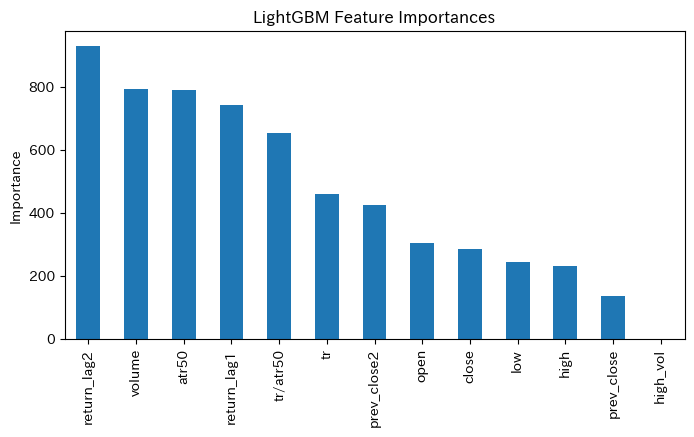

In [25]:
importances.plot.bar(figsize=(8,4))
plt.title("LightGBM Feature Importances")
plt.ylabel("Importance")
plt.show()

## **Result** <br>
Even LightGBM could not predict high/low that well. <br>
However, from Feature importance section, lagged return was apparently important <br>
so plugging bunch of past bars/wicks/... could improve the result. <br>

### **Things to improve**
1. **Cross Validation** <br>
    this time, i used 80% of earlier data to train the rest 20%. <br>
    however, in the real case, we use about 5000 data to predict next 1 so it should be CV'd that way. 
    <br>
<br>    
2. **Features** <br>
    in this case I only used few features about price data. <br>
    However, some features concerning momentums definitely should be there. #why? <br>
    Also as I stated earlier plugging bunch of past bars could improve the result <br>
    because including them better reflects local momentum, and vols <br>